#DCP Use for Pneumonia Classification on X-Ray images
---

Created by Sujeethan Vigneswaran. Check me out: www.sujeethanvigneswaran.com

QHacks 2021

Parallel processing is executed using the Distrobuted Compute Lab API (DCP)

Referenced from Amy Jang SWE @ Google (TensorFlow)


https://towardsdatascience.com/deep-learning-for-detecting-pneumonia-from-x-ray-images-fc9a3d9fdba8

##Setup DCP
---

In [ ]:
%%capture
!npm install -g n && n 10.20.1
!pip install git+https://github.com/Kings-Distributed-Systems/Bifrost
from bifrost import npm, node

In [ ]:
%%capture
npm.install('dcp-client')

In [ ]:
# UPLOAD DCP KEYSTORE FILE
# from google.colab import files
# KEYSTORE_NAME = list(files.upload().keys())[0]
# !mkdir -p ~/.dcp && cp /content/$KEYSTORE_NAME ~/.dcp/id.keystore && cp ~/.dcp/id.keystore ~/.dcp/default.keystore

In [ ]:
%%node

require('dcp-client').initSync();
const compute = require('dcp/compute');
const dcpCli = require('dcp/dcp-cli');

##Create Training & Validation Datasets
---

In [1]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
GCS_PATH = "gs://dcp-dataset"
IMAGE_SIZE = [180, 180]
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
EPOCHS = 25

In [3]:
filenames = tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/val/*/*')))
# Split training and validation data 80:20
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

In [4]:
train_list_ds = train_filenames
val_list_ds = val_filenames

In [ ]:
%%node

// # Define the decoding function that will be sent across the Distributed Computer Lab

decodingFunction = `async function(file_path) {

  tf = require('tfjs');
  tf.setBackend('cpu');

  progress(0);
  
  let parts = file_path.split("/");

  let label = parts[parts.length - 2] == "PNEUMONIA";

  img = tf.randomNormal([180,180]);
    
  img = tf.cast(img, 'float32');

// # img = tf.image.decode_jpeg(img, channels=3)
// # img = tf.image.resizeBilinear(img, [180,180])
  
  progress();

  progress(1.0);

  return [img, label];
}`;

// # Declare the function that will deploy the decoding job to the Distributed Computer

async function postTrainJob(datasetItem, myMaxRuntime) {

    let myKeystore = await dcpCli.getAccountKeystore();

    const job = compute.for(datasetItem, decodingFunction);

    let myTimer = setTimeout(function(){
        job.cancel();
        console.log('Job reached ' + myMaxRuntime + ' minutes.');
    }, myMaxRuntime * 60 * 1000);

    job.public.name = 'Distributed Computer Notebook: Pneumonia X-ray Image Decoding';
    job.requires(['aistensorflow/tfjs']);

    job.on('accepted', () => {
        console.log('Job accepted: ' + job.id);
    });
    job.on('status', (status) => {
        console.log('STATUS:');
        console.log(
            status.total + ' slices posted, ' +
            status.distributed + ' slices distributed, ' +
            status.computed + ' slices computed.'
        );
    });
    job.on('result', (thisOutput) => {
        console.log('RESULT:');
        console.log(thisOutput.result);
        train_ds.append(thisOutput.result);
        val_ds.append(thisOutput.result);
    });

    try {
        await job.exec(compute.marketValue, myKeystore);
    } catch (myError) {
        console.log('Job halted.');
        console.log(myError);
    }

    clearTimeout(myTimer);

    return(train_ds);
}

In [ ]:
#@markdown ### DCP Job Parameters

#@markdown Maximum runtime allowed for the job, in minutes:
max_runtime = 30 #@param {type:"slider", min:10, max:120, step:10}

train_ds = [];
val_ds = [];

In [ ]:
%%node
// # Training Dataset
// # Call functions to decode images, and deploy them to the Distributed Computer for processing in parallel

deployTime = Date.now();

postTrainJob(train_list_ds, max_runtime).then((value) => {
    console.log('Job complete.');

    let finalTime = Date.now() - deployTime;

    console.log('Total time to compute:');
    console.log((finalTime / 1000).toFixed(2) + ' seconds.');
});

postTrainJob(val_list_ds, max_runtime).then((value) => {
    console.log('Job complete.');

    let finalTime = Date.now() - deployTime;

    console.log('Total time to compute:');
    console.log((finalTime / 1000).toFixed(2) + ' seconds.');
});

###Dataset Viewing
---

In [5]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [6]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

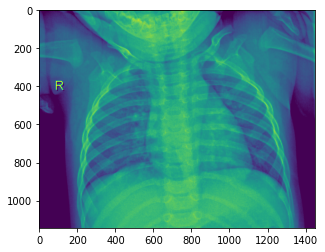

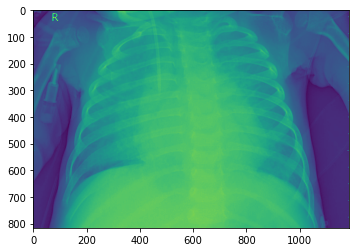

In [ ]:
from skimage import io
import matplotlib.pyplot as plt

normal_url = "https://storage.googleapis.com/dcp-dataset/chest_xray/train/NORMAL/IM-0131-0001.jpeg"
pneumonia_url = "https://storage.googleapis.com/dcp-dataset/chest_xray/train/PNEUMONIA/person1004_bacteria_2935.jpeg"

plt.subplots(1,1)
normal_image = io.imread(normal_url)
plt.imshow(normal_image)

plt.subplots(1,1)
pneumonia_image = io.imread(pneumonia_url)
plt.imshow(pneumonia_image)

plt.show()

##Build the CNN
---

In [7]:
# Big Chungus Model & Hyperparameter Tuning Created by Amy Jang from Google

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [8]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

with strategy.scope():
  model = build_model()
  METRICS = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/25
261/261 [==============================] - 544s 2s/step - loss: 0.5014 - accuracy: 0.7387 - precision: 0.9198 - recall: 0.7070 - val_loss: 0.6953 - val_accuracy: 0.7433 - val_precision: 0.7433 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 311s 1s/step - loss: 0.2592 - accuracy: 0.8987 - precision: 0.9643 - recall: 0.8953 - val_loss: 1.2406 - val_accuracy: 0.7433 - val_precision: 0.7433 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 316s 1s/step - loss: 0.1910 - accuracy: 0.9272 - precision: 0.9785 - recall: 0.9230 - val_loss: 0.1648 - val_accuracy: 0.9308 - val_precision: 0.9179 - val_recall: 0.9961
Epoch 4/25
261/261 [==============================] - 312s 1s/step - loss: 0.1729 - accuracy: 0.9398 - precision: 0.9816 - recall: 0.9365 - val_loss: 0.2165 - val_accuracy: 0.9317 - val_precision: 0.9916 - val_recall: 0.9160
Epoch 5/25
261/261 [==============================] - 314s 1s/step - loss: 0.1631 - accuracy: 0.9381

##Evaluate Model
---

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
new_model.summary()

loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))